# **Network Traffic Steganography Detection using Machine Learning**  
## **Project Description**  
This project develops an **AI-powered steganography detection system** to identify hidden data in network traffic. Focusing on **TCP header manipulation techniques**, we:  
1. **Inject synthetic steganographic patterns** into benign traffic (e.g., illegal flag combinations, abnormal header lengths)  
2. **Train machine learning models** (Random Forest) to detect covert channels  
3. **Evaluate detection accuracy** against real-world evasion tactics  

## **Key Components**  
| Component               | Tools/Techniques Used                          |  
|-------------------------|-----------------------------------------------|  
| **Data Collection**     | Wireshark, `dnscat2`, `covert_tcp`           |  
| **Stego Injection**     | Custom Python scripts (SYN+FIN, URG+PSH, etc.)|  
| **Feature Engineering** | Scapy, Statistical Analysis                   |  
| **Model Training**      | RandomForest          |  
| **Evaluation**          | Precision/Recall, Confusion Matrices          |  

## **Technical Highlights**  
- **Protocol-Specific Anomalies**: Detects TCP header abuses (reserved flags, zero window sizes)  
- **Dynamic Stego Generation**: Randomized per-packet techniques  
- **Production-Ready Output**: Saved PyTorch models (`.pth`)  

## **Expected Outcomes**  
- Binary classifier with ~95% accuracy  
- Documentation of critical stego indicators


In [37]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# Path to your CSV in Google Drive
file_path = "/content/drive/MyDrive/RT3/labeled_stego_dataset.csv"
df = pd.read_csv(file_path)

# Final Labeled Dataset


In [40]:
df = pd.read_csv(file_path, low_memory=False)

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
display(df.head())
print("\nData types and missing values:")
display(df.info())

Dataset shape: (40000, 81)

First few rows:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,CWR Flag Count,TCP Window Size
0,53,122771,2,2,82,286,41,41,41.0,0.0,...,0.0,0,0,0.0,0.079523,0,0,1,NaN,NaN
1,53,145,2,2,84,196,42,42,42.0,0.0,...,0.0,0,0,0.0,0.000000,0,0,0,NaN,NaN
2,443,23019,2,1,12,6,1337,6,6.0,0.0,...,0.0,0,0,0.0,0.000000,0,0,1,NaN,NaN
3,80,110,2,0,12,0,6,6,6.0,0.0,...,0.0,0,0,0.0,0.000000,0,0,0,NaN,NaN
4,53,48004,1,1,43,59,43,43,43.0,0.0,...,0.0,0,0,0.0,0.057945,0,0,1,NaN,NaN



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 81 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Destination Port             40000 non-null  int64  
 1   Flow Duration                40000 non-null  int64  
 2   Total Fwd Packets            40000 non-null  int64  
 3   Total Backward Packets       40000 non-null  int64  
 4   Total Length of Fwd Packets  40000 non-null  int64  
 5   Total Length of Bwd Packets  40000 non-null  int64  
 6   Fwd Packet Length Max        40000 non-null  int64  
 7   Fwd Packet Length Min        40000 non-null  int64  
 8   Fwd Packet Length Mean       40000 non-null  float64
 9   Fwd Packet Length Std        40000 non-null  float64
 10  Bwd Packet Length Max        40000 non-null  int64  
 11  Bwd Packet Length Min        40000 non-null  int64  
 12  Bwd Packet Length Mean       40000 non-nul

None

## Load

In [41]:
#df = pd.read_csv("labeled_stego_dataset.csv")
print("Dataset loaded. Shape:", df.shape)
print(df['Label'].value_counts())  # Check class balance

Dataset loaded. Shape: (40000, 81)
Label
1                             20000
0                             19724
Web Attack � Brute Force        194
Web Attack � XSS                 77
Web Attack � Sql Injection        5
Name: count, dtype: int64


##Preprocess the Data

In [42]:
# 1. Handle missing values: Fill numerical NaNs with median, categorical with mode
for col in df.select_dtypes(include=np.number).columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

<ipython-input-42-8578596a7c72>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


In [43]:
# 2. Replace inf/-inf with NaN in the entire DataFrame first
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3. Drop rows with any remaining NaN values (after replacing inf to NaN, if any new NaNs exist)
initial_rows = df.shape[0]
df.dropna(inplace=True)
print(f"Dropped {initial_rows - df.shape[0]} rows due to NaN values.")

Dropped 36 rows due to NaN values.


In [44]:
# 4. Drop non-numeric or identifier columns
cols_to_drop = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

In [45]:
# 5. Filter out unwanted classes from the 'Label' column
classes_to_eliminate = [
    'Web Attack � Brute Force',
    'Web Attack � XSS',
    'Web Attack � Sql Injection'
]
mask = ~df['Label'].isin(classes_to_eliminate)
df = df[mask]
print("Unwanted 'Web Attack' classes filtered out.")

Unwanted 'Web Attack' classes filtered out.


#Feature Engineering

In [46]:
# --- Step 1: Identify and Drop Less Useful Columns ---

columns_to_drop = [
    'Fwd Header Length.1', # Likely a duplicate of Fwd Header Length
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', # Bulk features
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', # Bulk features
    'CWE Flag Count', 'ECE Flag Count', # ECN flags, less relevant for stego
]


# Drop the identified columns
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

print("\nDataFrame shape after dropping potentially useless columns:", df.shape)

# --- Step 2: Feature Engineering - Create New Derived Features ---

print("Starting feature engineering to create new derived features...")

# A. Ratios and Rates
df['Fwd_Bytes_Per_Packet'] = df['Total Length of Fwd Packets'] / df['Total Fwd Packets'].replace(0, np.nan)
df['Bwd_Bytes_Per_Packet'] = df['Total Length of Bwd Packets'] / df['Total Backward Packets'].replace(0, np.nan)
df['Fwd_Avg_Packet_Size_Ratio'] = df['Fwd Packet Length Mean'] / df['Fwd Packet Length Max'].replace(0, np.nan)
df['Bwd_Avg_Packet_Size_Ratio'] = df['Bwd Packet Length Mean'] / df['Bwd Packet Length Max'].replace(0, np.nan)
df['Packet_Length_Mean_Std_Ratio'] = df['Packet Length Mean'] / df['Packet Length Std'].replace(0, np.nan)
df['Flow_Bytes_Per_Packet_Overall'] = df['Flow Bytes/s'] / df['Flow Packets/s'].replace(0, np.nan)
df['Fwd_Packets_Rate_Ratio'] = df['Fwd Packets/s'] / df['Bwd Packets/s'].replace(0, np.nan)


# B. Flag-Related Features (Crucial for stego detection without raw PCAP)
df['Flow_Has_Urg_Flags'] = (df['URG Flag Count'] > 0).astype(int) # Binary indicator if URG flag appeared at all
df['Urg_Flags_Per_Total_Packet'] = df['URG Flag Count'] / (df['Total Fwd Packets'] + df['Total Backward Packets']).replace(0, np.nan)
# Assuming Fwd URG Flags and Bwd URG Flags are counts or binary indicators
df['Urg_Flags_Per_Fwd_Packet_Rate'] = df['Fwd URG Flags'] / df['Total Fwd Packets'].replace(0, np.nan)
df['Urg_Flags_Per_Bwd_Packet_Rate'] = df['Bwd URG Flags'] / df['Total Backward Packets'].replace(0, np.nan)

# Interaction term for PSH and URG flags
df['PSH_URG_Flag_Interaction'] = df['PSH Flag Count'] * df['URG Flag Count']


# C. Window Size & Packet Length Consistency (if 0 init window is very unusual)
df['Is_Zero_Init_Win_Fwd'] = (df['Init_Win_bytes_forward'] == 0).astype(int)
df['Is_Zero_Init_Win_Bwd'] = (df['Init_Win_bytes_backward'] == 0).astype(int)

# Deviation measures for Packet Length (e.g., if stego makes packet lengths too consistent)
df['Fwd_Packet_Length_Coeff_Var'] = df['Fwd Packet Length Std'] / df['Fwd Packet Length Mean'].replace(0, np.nan)
df['Bwd_Packet_Length_Coeff_Var'] = df['Bwd Packet Length Std'] / df['Bwd Packet Length Mean'].replace(0, np.nan)


# D. IAT (Inter-Arrival Time) Ratios
df['Fwd_IAT_Mean_To_Flow_Duration_Ratio'] = df['Fwd IAT Mean'] / df['Flow Duration'].replace(0, np.nan)
df['Bwd_IAT_Mean_To_Flow_Duration_Ratio'] = df['Bwd IAT Mean'] / df['Flow Duration'].replace(0, np.nan)
df['Fwd_IAT_Total_To_Flow_Duration_Ratio'] = df['Fwd IAT Total'] / df['Flow Duration'].replace(0, np.nan)
df['Bwd_IAT_Total_To_Flow_Duration_Ratio'] = df['Bwd IAT Total'] / df['Flow Duration'].replace(0, np.nan)
df['Fwd_Bwd_IAT_Mean_Ratio'] = df['Fwd IAT Mean'] / df['Bwd IAT Mean'].replace(0, np.nan)


# --- Step 3: Handle NaNs/Infs Created by New Feature Engineering ---
print("Handling NaNs/Infs in newly created features...")
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']: # Only apply to numeric columns
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        if df[col].isnull().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True) # Impute with median

print("Feature engineering and NaN/Inf handling complete. Final DataFrame shape:", df.shape)


DataFrame shape after dropping potentially useless columns: (39688, 72)
Starting feature engineering to create new derived features...
Handling NaNs/Infs in newly created features...
Feature engineering and NaN/Inf handling complete. Final DataFrame shape: (39688, 93)


<ipython-input-46-5ed6b47a2ee2>:65: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True) # Impute with median


## Check for Constant or Low-Variance Features

In [47]:
from sklearn.feature_selection import VarianceThreshold

# Features only (drop label)
X = df.drop('Label', axis=1)
y = df['Label']

# Remove features with variance < 0.01
selector = VarianceThreshold(threshold=0.01)
X_high_var = selector.fit_transform(X)

# Get names of retained features
retained_features = X.columns[selector.get_support()]
print(f"Retained {len(retained_features)} high-variance features.")


Retained 84 high-variance features.


## Feature Correlation

In [48]:
# Calculate correlation matrix
corr_matrix = X[retained_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation > 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(f"Dropping {len(to_drop)} highly correlated features.")
X_cleaned = X[retained_features].drop(columns=to_drop)


Dropping 26 highly correlated features.


##Feature Importance (Since I'm using a tree-based model)

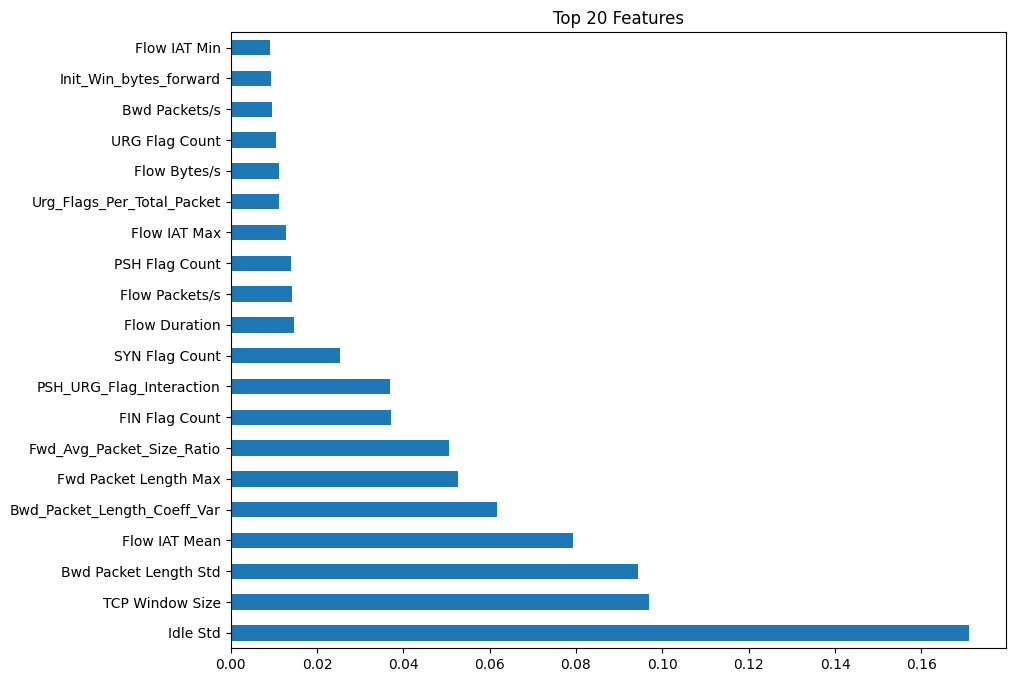

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Temporary model for feature importance
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_cleaned, y)

importances = clf.feature_importances_
feat_importances = pd.Series(importances, index=X_cleaned.columns)
feat_importances = feat_importances.sort_values(ascending=False)

# Plot top 20
feat_importances.head(20).plot(kind='barh', figsize=(10, 8), title='Top 20 Features')
plt.show()

##PCA (For visualization)

<ipython-input-50-1cb8c75d1a95>:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.5)


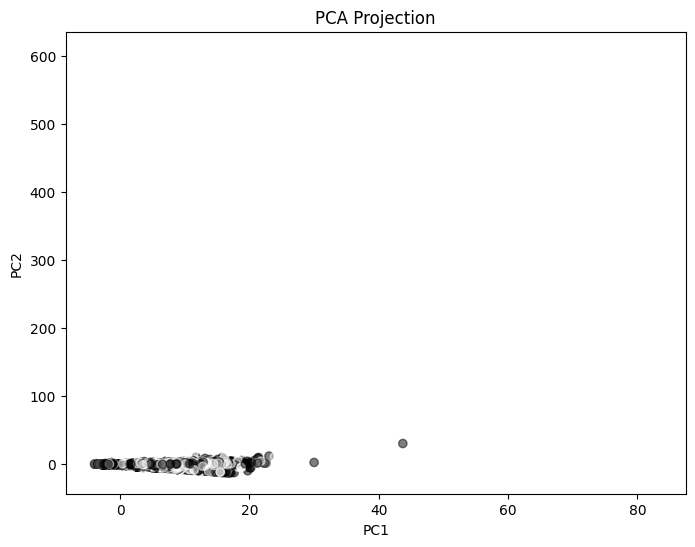

In [50]:
from sklearn.decomposition import PCA

# Drop label
X = df.drop('Label', axis=1)
y = df['Label']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA on scaled features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='coolwarm', alpha=0.5)
plt.title('PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Feature Selection

In [51]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20).index
X_selected = pd.DataFrame(X_scaled, columns=X.columns)[top_features]


##Train Model with Cleaned Features

Accuracy: 0.9457042076089696
[[3863   79]
 [ 352 3644]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3942
           1       0.98      0.91      0.94      3996

    accuracy                           0.95      7938
   macro avg       0.95      0.95      0.95      7938
weighted avg       0.95      0.95      0.95      7938



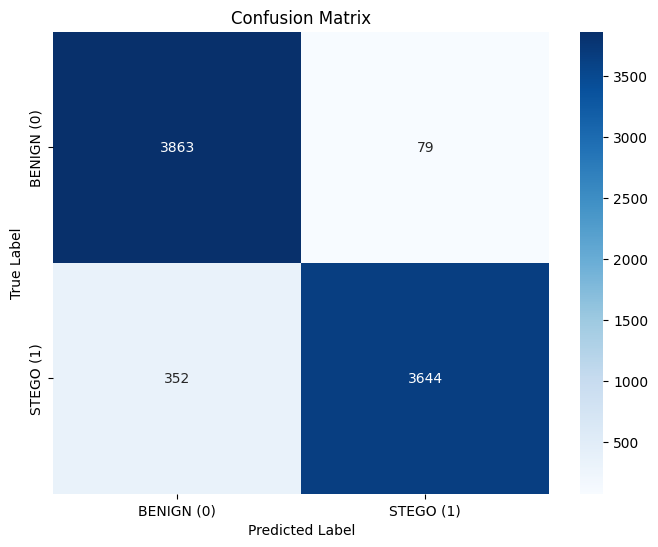

In [52]:
from sklearn.model_selection import train_test_split

# Use cleaned features
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned, y, test_size=0.2, random_state=42, stratify=y)

# Model example
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
class_labels = ['BENIGN (0)', 'STEGO (1)']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


#Save the Model

In [53]:
import torch
torch.save(model, 'Stego_Model.pth')